In [1]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from h3 import h3
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.graphics.gofplots import qqplot
import scipy as sp
import numpy as np
from math import sqrt
from sklearn import linear_model,metrics,preprocessing
from sklearn.model_selection import train_test_split

# Part 1: Exploratory data analysis

# Process Data to facilitate EDA
- Read Data
- Define helper functions
- Add derived features 

In [2]:
# Read Data
bike_trips_data = pd.read_excel('bike_trip_details.xlsx')


# Define helper functions
def get_hex_id(lat,long,res=8):
    return h3.geo_to_h3(lat,long, res)


def get_part_of_day(hour):
    return (
        "morning" if 5 <= hour <= 11
        else
        "afternoon" if 12 <= hour <= 17
        else
        "evening" if 18 <= hour <= 22
        else
        "night")


def get_weekday(day):
    return ("weekday" if day < 5 else "weekend" )

# Add additional features
bike_trips_data['pick_hex_id'] = bike_trips_data.apply(lambda x: get_hex_id(x.pick_lat, x.pick_lng), axis=1)
bike_trips_data['drop_hex_id'] = bike_trips_data.apply(lambda x: get_hex_id(x.drop_lat, x.drop_lng), axis=1)
bike_trips_data['date_time']=bike_trips_data['timestamp'].apply(lambda x : datetime.fromtimestamp(x/1000))
bike_trips_data['part_of_day']=bike_trips_data['date_time'].apply(lambda x : get_part_of_day(x.hour))
bike_trips_data['weekday']=bike_trips_data['date_time'].apply(lambda x : get_weekday(x.weekday()))

# Identify Missing Values
- There are no null/NA values in the data
- For travel distance there are records with incorrect distances (0 and -1) which are assumed to be missing
- Imputation scheme for these values is to use `average fare/unit distance` or `average distance/unit time` and use available fare or time to impute values 

In [3]:
#Check if any value is null
bike_trips_data.isnull().values.any()

False

In [4]:
# Get records with incorrectly captured travel_distance which is treated as missing
df_ouliers = bike_trips_data[(bike_trips_data.travel_distance <=0)]

# This results in 234 records
df_ouliers.shape[0]

234

# Exploratory Data Analysis and Profiling
- Quick look at key statistics to spot any gross inconsistencies
- Look at distribution of features
- Find how trips are divided across day/week parts
- See how features correlate with each other

In [5]:
# Use in-built method for high level data profiling
# This does not point out any glaring inconsitencies except for negative values in travel_distance
bike_trips_data.describe()

,timestamp,pick_lat,pick_lng,drop_lat,drop_lng,travel_distance,travel_time,trip_fare
count,4.458700e+04,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000,44587.000000
mean,1.546632e+12,17.427598,17.427598,17.427520,17.427520,5.094359,15.819835,53.872833
std,1.518684e+08,0.030151,0.030151,0.037690,0.037690,3.365008,23.462865,33.430462
min,1.546368e+12,17.330339,17.330339,12.921696,12.921696,-1.000000,0.022750,20.000000
25%,1.546503e+12,17.404811,17.404811,17.405149,17.405149,2.744500,8.428525,36.000000
50%,1.546611e+12,17.431681,17.431681,17.430460,17.430460,4.299000,13.126250,46.000000
75%,1.546772e+12,17.446578,17.446578,17.446780,17.446780,6.679500,20.111167,60.000000
max,1.546886e+12,17.528885,17.528885,17.736155,17.736155,52.801000,4134.388700,1670.000000


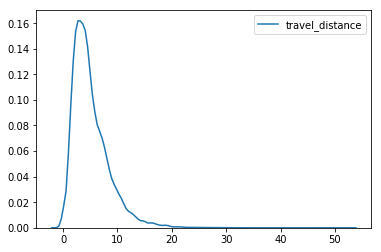

In [6]:
# Distributions are almost normal
sns.kdeplot(bike_trips_data['travel_distance'])
plt.show()
# towards the tail we can see unusual trave

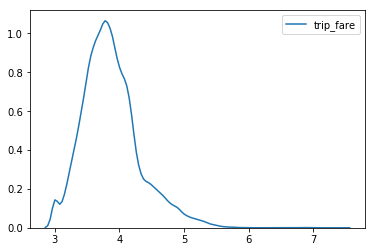

In [7]:
# trip_fare and travel_time on plotted on logarithmic scale as the there is a huge range difference
sns.kdeplot(np.log(bike_trips_data['trip_fare']))
plt.show()

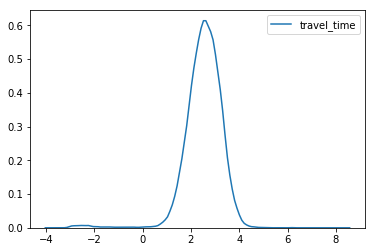

In [8]:
sns.kdeplot(np.log(bike_trips_data['travel_time']))
plt.show()

In [9]:
# Create trip count aggregates by part pf day and part of week
df_trips_by_daypart = bike_trips_data.groupby(['part_of_day'])['trip_id'].count().reset_index()
df_trips_by_daypart.rename(columns={'trip_id':'trip_count'}, inplace=True)
df_trips_by_weekpart = bike_trips_data.groupby(['weekday'])['trip_id'].count().reset_index()
df_trips_by_weekpart.rename(columns={'trip_id':'trip_count'}, inplace=True)

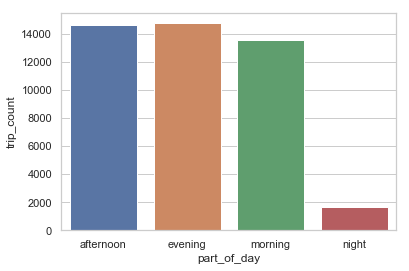

In [10]:
sns.set(style="whitegrid")
sns.barplot(x="part_of_day", y="trip_count", data=df_trips_by_daypart)
plt.show()

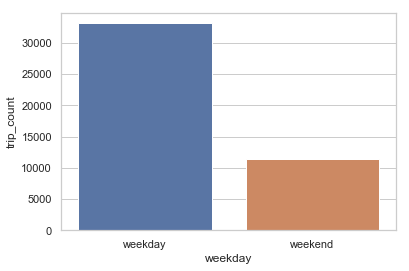

In [11]:
sns.set(style="whitegrid")
sns.barplot(x="weekday", y="trip_count", data=df_trips_by_weekpart)
plt.show()

In [12]:
# Mean travel time aggregates
bike_trips_data.groupby(['weekday','part_of_day'])['travel_time'].mean().reset_index()

,weekday,part_of_day,travel_time
0,weekday,afternoon,15.756404
1,weekday,evening,16.567440
2,weekday,morning,15.951253
3,weekday,night,13.988077
4,weekend,afternoon,15.569811
5,weekend,evening,15.916086
6,weekend,morning,14.211516
7,weekend,night,12.975616


In [13]:
# Mean travel distance aggregates
bike_trips_data.groupby(['weekday','part_of_day'])['travel_distance'].mean().reset_index()

,weekday,part_of_day,travel_distance
0,weekday,afternoon,4.954607
1,weekday,evening,4.995205
2,weekday,morning,5.110616
3,weekday,night,5.263930
4,weekend,afternoon,5.144247
5,weekend,evening,5.342353
6,weekend,morning,5.389432
7,weekend,night,5.438874


In [14]:
#preparing data for scatter pair plot
df_scatter_data = bike_trips_data[['travel_distance','travel_time','trip_fare']]
df_scatter_data['travel_time'] = np.log(df_scatter_data['travel_time'])
df_scatter_data['trip_fare'] = np.log(df_scatter_data['trip_fare'])

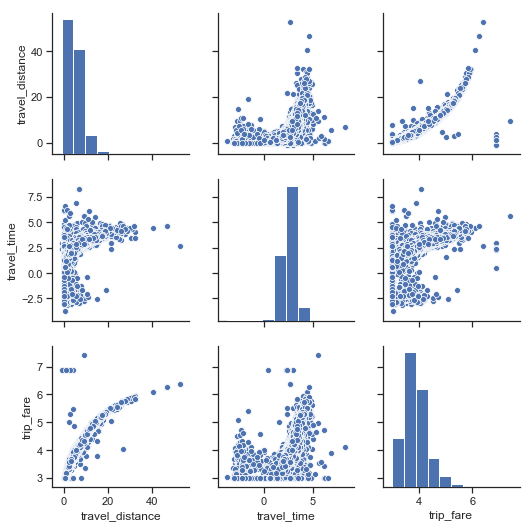

In [15]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(df_scatter_data)
plt.show()

In [16]:
#Correlation Matrix
df_scatter_data.corr()

,travel_distance,travel_time,trip_fare
travel_distance,1.000000,0.694492,0.969492
travel_time,0.694492,1.000000,0.742184
trip_fare,0.969492,0.742184,1.000000


# Identifying outliers in the data
- The problem is to identify anamolies using multiple variables. Mahalanobis distance is an effective multivariate distance metric that measures the distance between a point and a distribution.It is an extremely useful metric having, excellent applications in multivariate anomaly detection. (https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7)

- We use this multivariate anamoly because fare is dependent on distance and time trave and univariate would not be correct approach

- we then plot log of calculated Mahalanobis distance and find the the upper range after which points can be labelled as outliers

- Additional anamolies are removed by IQR method on speed (derived feature)

In [17]:
def calculate_mahalanobis_distance(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# removing non-positive distances as they are not being imputed
bike_trips_data = bike_trips_data[bike_trips_data.travel_distance>0]

bike_trips_data['mahalanobis_distance'] = calculate_mahalanobis_distance(x=bike_trips_data[['travel_distance', 'trip_fare']], \
                                        data=bike_trips_data[['travel_distance', 'trip_fare']])

In [18]:
#calculate log of mahalanobis_distance to plot distribution
bike_trips_data['mahalanobis_distance_log'] = np.log(bike_trips_data['mahalanobis_distance'])

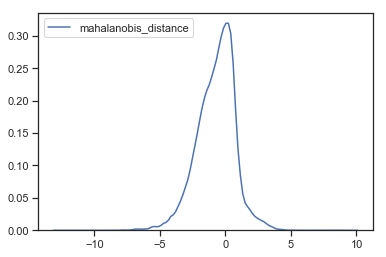

In [19]:
sns.kdeplot(np.log(bike_trips_data['mahalanobis_distance']))
plt.show()

In [20]:
anamolies = bike_trips_data[bike_trips_data['mahalanobis_distance_log']>5].reset_index(drop=True)

In [21]:
anamolies[['travel_distance','travel_time','travel_time','mahalanobis_distance_log']]
# the values seems to be outlier by general sense as well
# 1670 fare for 9 kmm is an outlier
# 959 fare for 1 km is definitely not accurate

,travel_distance,travel_time,travel_time,mahalanobis_distance_log
0,27.000,70.498000,70.498000,5.546320
1,52.801,14.164500,14.164500,5.630561
2,3.000,10.423133,10.423133,5.090359
3,46.747,98.218850,98.218850,5.339610
4,4.000,103.663667,103.663667,5.358221
5,4.000,10.143917,10.143917,8.491110
6,2.700,10.949667,10.949667,8.516316
7,1.000,1.596217,1.596217,8.548891
8,9.400,267.825483,267.825483,9.581129


In [22]:
# Remove Anamolies before running second anamoly detection method
bike_trips_data = bike_trips_data[~bike_trips_data.trip_id.isin(anamolies.trip_id)].reset_index(drop=True)

# add speed as a auxiliary variable
bike_trips_data['speed'] = (bike_trips_data['travel_distance']/bike_trips_data['travel_time'])*60

In [23]:
def get_anamolies_by_speed(df_in, col_name):
    """
    given the data frame removes the outlier as per quantile range 
    returns : the data frame with anamolies
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    print("IQR lower speed as per data is  {low}".format(low=round(fence_low,4)))
    print("IQR higher speed as per data is {high}".format(high=round(fence_high,4)))
    df_out = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] >fence_high)]
    print('-------------------------------------')
    print("Count of anamolies in data is {}".format(df_out.shape[0]))
    
    return df_out

In [24]:
anamolies_by_speed = get_anamolies_by_speed(bike_trips_data,'speed')

IQR lower speed as per data is  4.0014
IQR higher speed as per data is 36.274
-------------------------------------
Count of anamolies in data is 1173


-as we can see 1173 values are found to be anamoly as per the data where lower fence for speed is 4
and higher fence is 36.2

-here speed is choosen because this parameter will not be much effected even if captain takes 50 km ride or a 2 km ride

-The data has speed as low as 0.000238 kmph and high as 11878 kmph, which are clearly outliers/anamolies

In [25]:
#Sample of outliers by virtue of low speed
anamolies_by_speed[['travel_time','travel_distance','trip_fare','speed']].sort_values(by='speed').reset_index(drop=True).head(5)

,travel_time,travel_distance,trip_fare,speed
0,504.808017,0.002,20,0.000238
1,29.470933,0.001,20,0.002036
2,128.724917,0.005,20,0.002331
3,6.668383,0.001,20,0.008998
4,19.428517,0.004,20,0.012353


In [26]:
#Sample of outliers by virtue of high speed
anamolies_by_speed[['travel_time','travel_distance','trip_fare','speed']].sort_values(by='speed',ascending=False).reset_index(drop=True).head(5)

,travel_time,travel_distance,trip_fare,speed
0,0.075300,14.908,162,11878.884462
1,0.065133,9.419,91,8676.663699
2,0.052483,6.650,59,7602.413947
3,0.054417,6.766,58,7460.213938
4,0.054417,6.567,52,7240.795881


In [27]:
# Remove Anamolies of speed from the data set 
bike_trips_data = bike_trips_data[~bike_trips_data.trip_id.isin(anamolies_by_speed.trip_id)].reset_index(drop=True)

# Part 2: Metric calculation

In [28]:
bike_trips_data_for_metric_calculation = pd.read_excel('bike_trip_details.xlsx')

def avg_duration_between_first_and_second_trip(trips_data):
    # to get datetime from the timestamp
    trips_data['date_time']=trips_data['timestamp'].apply(lambda x : datetime.fromtimestamp(x/1000))
    trips_of_cus_more_than_one_trxn = trips_data.copy()
    # to get the lag date_time value or previous ride date_time of each trip
    trips_of_cus_more_than_one_trxn['lagged_date']  = trips_data.sort_values(by=['date_time'], ascending=True).groupby(['customer_id'])['date_time'].shift(1)
    # gives you the data of the second ride of each cutomer which has previous ride time i.e first ride
    trips_with_first_and_second_trxn_time = trips_of_cus_more_than_one_trxn.sort_values(by= ['customer_id','date_time']).groupby('customer_id').nth(1).reset_index()
    trips_with_first_and_second_trxn_time['time_diff'] = trips_with_first_and_second_trxn_time['date_time'] - trips_with_first_and_second_trxn_time['lagged_date']
    return trips_with_first_and_second_trxn_time.time_diff.mean()


In [29]:
avg_dur = avg_duration_between_first_and_second_trip(bike_trips_data_for_metric_calculation)
print('-------------------------------------')
print("average duration between the 1st trip and the 2nd trip of customers {}".format(avg_dur))

-------------------------------------
average duration between the 1st trip and the 2nd trip of customers 1 days 00:47:09.691580


# Part 3: Model building

# To add interaction term  

- In statistics, an interaction may arise when considering the relationship among three or more variables, and describes a situation in which the effect of one causal variable on an outcome depends on the state of a second causal variable (that is, when effects of the two causes are not additive) (https://en.wikipedia.org/wiki/Interaction_(statistics))
-  It means that the slope of one continuous variable on the response variable changes as the values on a second continuous change.
- In our case the interaction occurs as the value of distance increases the time would also increase, hence the addition of interaction term

In [30]:
bike_trips_data['interaction_term'] = bike_trips_data['travel_distance'] * bike_trips_data['travel_time']

In [31]:
def model_to_predict_trip_fare(bike_trips_data):
    df_features = bike_trips_data[['travel_distance','travel_time','interaction_term']]
    df_target = bike_trips_data[['trip_fare']]
    # Linear Regression Model
    lm = linear_model.LinearRegression()
    # split of data into 70% train data and 30% test data
    X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.30, random_state=42)
    model = lm.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    rmse = sqrt(metrics.mean_squared_error(y_pred,y_test))
    print('-------------------------------------')
    print("Root mean square error(RMSE): {}".format(rmse))
    print("coefficient of determination R^2 of the prediction: {}".format(model.score(X_train,y_train)))
    print("Intercept: {}".format(model.intercept_))
    print("coefficients for travel_distance,travel_time,interaction_term  are: {}".format(model.coef_))
              
    return model

In [32]:
# will use the bike_trips_data dataframe whose anamolies are removed in the EDA process
fare_predictor = model_to_predict_trip_fare(bike_trips_data)

-------------------------------------
Root mean square error(RMSE): 5.144140965038108
coefficient of determination R^2 of the prediction: 0.9732331814994909
Intercept: [19.61198968]
coefficients for travel_distance,travel_time,interaction_term  are: [[ 6.74217228 -0.62905126  0.08817934]]


In [33]:
# predict trip_fare for a trip with travel_distance of 3.5 kms and travel_time of 15 minutes. 
print('-------------------------------------')
print("predicted trip_fare for a trip with travel_distance of 3.5 kms and travel_time of 15 minutes is ")
# Input 3.5 km of distance and 15 minutes of time and 3.5*15 a interaction term to predictor
print("{} Rupees".format(fare_predictor.predict([[3.5,15,3.5*15]])[:][0][0]))

-------------------------------------
predicted trip_fare for a trip with travel_distance of 3.5 kms and travel_time of 15 minutes is 
38.403239013504354 Rupees


# Part 4: Top Hex clusters

In [34]:
bike_trips_data_for_Top_Hex_clusters = pd.read_excel('bike_trip_details.xlsx')
bike_trips_data_for_Top_Hex_clusters['pick_hex_id'] = bike_trips_data_for_Top_Hex_clusters.apply(lambda x: get_hex_id(x.pick_lat, x.pick_lng), axis=1)
bike_trips_data_for_Top_Hex_clusters['drop_hex_id'] = bike_trips_data_for_Top_Hex_clusters.apply(lambda x: get_hex_id(x.drop_lat, x.drop_lng), axis=1)

def top_five_hex_cluster(trips_data):
    """
    To find top five cluster pair where source cluster and destination cluster can be same
    i.e the ride within cluster are also considered.
    """
    # to get trip count's between clusters
    pairs_hex = trips_data.groupby(['pick_hex_id','drop_hex_id'])['trip_id'].nunique().reset_index().sort_values(by='trip_id',ascending=False)
    pairs_hex.rename(columns={"trip_id":"Total trips"},inplace=True)
    pairs_hex['Hex pair(source_hex_id,destination_hex_id)'] = pairs_hex['pick_hex_id'].astype(str) + ' to ' \
                                                                  + pairs_hex['drop_hex_id'].astype(str) 
    # to get top 5 clusters by trip count
    top_pairs_hex = pairs_hex.head(5).reset_index(drop=True)
    top_pairs_hex['Rank'] = top_pairs_hex.index + 1
    return top_pairs_hex[['Rank','Hex pair(source_hex_id,destination_hex_id)','Total trips']]

In [35]:
top_five_hex_cluster(bike_trips_data_for_Top_Hex_clusters)

,Rank,"Hex pair(source_hex_id,destination_hex_id)",Total trips
0,1,88586da335fffff to 88586da335fffff,1064
1,2,88586da335fffff to 88586da149fffff,762
2,3,88586da149fffff to 88586da335fffff,731
3,4,88586da331fffff to 88586da335fffff,697
4,5,88586da149fffff to 88586da149fffff,692


In [36]:
def top_five_hex_cluster_with_no_trips_in_same_clusters(trips_data):
    """
    To find top five cluster pair where source cluster and destination cluster are distinct
    i.e only rides between two clusters are considered.
    """
    # to remove trips in the same clusters
    trips_data = trips_data[trips_data['pick_hex_id'] != trips_data['drop_hex_id']].reset_index(drop=True)
    # to get trip count's between clusters
    pairs_hex = trips_data.groupby(['pick_hex_id','drop_hex_id'])['trip_id'].nunique().reset_index().sort_values(by='trip_id',ascending=False)
    pairs_hex.rename(columns={"trip_id":"Total trips"},inplace=True)
    
    pairs_hex['Hex pair(source_hex_id,destination_hex_id)'] = pairs_hex['pick_hex_id'].astype(str) + ' to ' \
                                                                  + pairs_hex['drop_hex_id'].astype(str) 
    # to get top 5 clusters by trip count
    top_pairs_hex = pairs_hex.head(5).reset_index(drop=True)
    top_pairs_hex['Rank'] = top_pairs_hex.index + 1
    return top_pairs_hex[['Rank','Hex pair(source_hex_id,destination_hex_id)','Total trips']]

In [37]:
top_five_hex_cluster_with_no_trips_in_same_clusters(bike_trips_data_for_Top_Hex_clusters)

,Rank,"Hex pair(source_hex_id,destination_hex_id)",Total trips
0,1,88586da335fffff to 88586da149fffff,762
1,2,88586da149fffff to 88586da335fffff,731
2,3,88586da331fffff to 88586da335fffff,697
3,4,88586da335fffff to 88586da331fffff,681
4,5,88586da149fffff to 88586da14dfffff,485
